# Logistic Regression Demo with Gradient Ascent


We study fitting the logistic regression model with gradient ascent. In logistic regression we observe data $(x_i,y_i)$ where the $x_i \in \mathbb{R}^p$ are known as predictors, features, or attributes. The response $y_i \in \{0,1\}$ is binary. We would like to know how $x$ affects $y$. For example, does $y$ tend to be $1$ when certain elements of $x$ are large? 

In such cases it is not appropriate to model $y$ as a linear function of $x$ because a linear function will make predictions outside of the interval $[0,1]$. Instead we can model $y_i \sim Bernoulli(p_i)$. In other words $P(Y_i = 1) = p_i$ and $P(Y_i = 0) = 1-p_i$. We then relate the $p_i$ to the $x_i$ through the logistic function

$$ p_i = \frac{1}{1 + e^{x_i^T\beta}}$$

In this Equation $\beta$ is unknown. We estimate it from the data. $p_i$ is also unknown. Once we have an estimate of $\beta$, we can use it to produce an estimate of $p_i$. There are many other possible forms of the equation for linking the $x_i$ with $p_i$, but the logistic function is the most common.

See [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) or Chapter 14 of Lange for more background on logistic regression.

We begin by simulating some data from the model. We consider a 1-dimensional case with an intercept, so $p=2$.

In [37]:
set.seed(1234)
beta <- c(2,1)
n <- 100
x <- seq(from=-5,to=5,length.out=n)

In [38]:
## computes the p_i for any x_i and beta
logistic <- function(x,beta){
    return( 1 / (1+exp(-sum(x*beta))))
}

In [39]:
X <- cbind(1,x)

In [40]:
logistic(X[1,],beta)

[1] 0.04742587

In [41]:
## to compute the logistic function for all observations, use the
## apply function. this computer logistic(z,beta) where z is 
## any from of X
p <- apply(X,1,function(z){logistic(z,beta)})

In [42]:
y <- rbinom(n=n,size=1,prob=p)

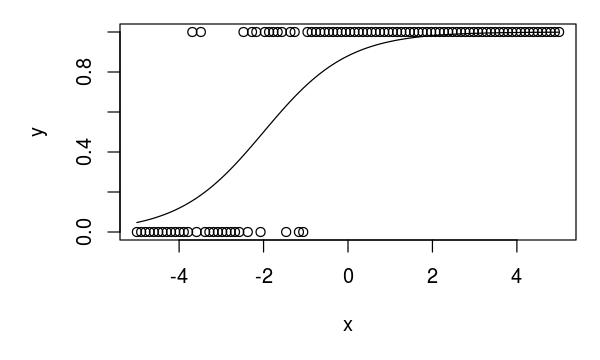

In [43]:
options(repr.plot.height=3,repr.plot.width=5)
par(mar=c(5,5,1,1))
plot(x,y)
points(x,p,type='l')

**Exercise:** Try altering the value of $\beta$ and observe how the data and curve change. Can you predict this behavior from the form of the logistic function?

## Log Likelihood Contours

We will maximize the logistic log likelihood. The likelihood is
\begin{align*}
L(\beta|X,Y) &= \prod_{i=1}^n f(y_i|\beta,x_i)\\
&= \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i}
\end{align*}

So the log likelihood is
$$ \log L(\beta|X,Y) = \sum_{i=1}^n \left(y_i \log p_i + (1-y_i)\log(1-p_i)\right)$$

Before we find the $\beta$ which maximizes $\log L$, we first plot the contours.

In [44]:
logistic_loglik <- function(beta,X,y){
        p <- apply(X,1,function(z){logistic(z,beta)})
        return(sum(y*log(p) + (1-y)*log(1-p)))
}

In [45]:
## make contour plots using ggplot2
library(ggplot2)

In [46]:
## make grid, centered near true beta values
N <- 100
beta1g <- seq(beta[1] - 4,beta[1] + 4,length.out=N)
beta2g <- seq(beta[2] - 4,beta[2] + 4,length.out=N)
beta_grid <- cbind(rep(beta1g,N),rep(beta2g,each=N))
beta_grid <- cbind(beta_grid,apply(beta_grid,1,function(z){ logistic_loglik(z,X,y) } ))

In [47]:
## ggplot likes data frames
beta_grid <- as.data.frame(beta_grid)
names(beta_grid) <- c("beta1","beta2","log_like")

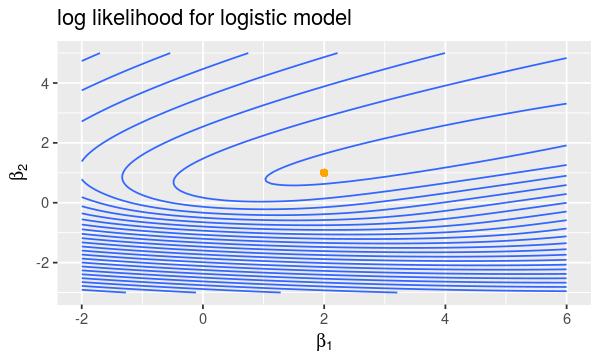

In [48]:
v <- ggplot(beta_grid, aes(beta1, beta2,z = log_like))
v <- v + geom_contour(bins=25)
v <- v +  labs(
        x = quote(beta[1]),
        y = quote(beta[2])
      )
v <- v +  geom_point(aes(x=beta[1],y=beta[2]), color="orange")
v + labs(title = "log likelihood for logistic model")
##v + geom_raster(aes(fill = density)) +
##      geom_contour(colour = "white")

Note that the true beta (orange point above) is the true parameter value, not the maximum likelihood estimate. The value which maximizes the likelihood should be near, but not necessarily at, the truth. We will learn to quantify this uncertainty in future lectures.

** Exercise: ** Put a nice legend on this plot defining the orange point as the true parameter value and the blue lines as contours.

## Fit with Gradient Ascent

Fit logistic model with gradient ascent and step halving. We start by computing the gradient of the log likelihood.

$$\frac{d\log L(\beta|X,Y)}{d\beta} = \sum_{i=1}^n \underbrace{\left(\frac{y_i}{p_i} - \frac{1-y_i}{1-p_i}\right)}_{\equiv t_i}\frac{dp_i}{d\beta}$$

and

$$ \frac{dp_i}{d\beta} = \underbrace{(1+e^{-x_i^T\beta})^{-2}e^{-x_i^T\beta}}_{\equiv s_i}x_i$$

Note that the gradient can be expressed very compactly in R notation as
$$\text{colSums(X*s*t)}$$

In [49]:
## number of iterations, in practice we stop once converged
## we discuss convergence in future lectures
Niter <- 100
## initial value to start
initial_beta <- c(0,0)
## store iterates
beta_hat <- matrix(0,nrow=Niter+1,ncol=length(beta))
colnames(beta_hat) <- c("beta1","beta2")
beta_hat[1,] <- initial_beta
for(ii in 1:Niter){
    pre <- apply(X,1,function(z){exp(-sum(z*beta_hat[ii,]))})
    p <- 1 / (1+pre)
    s <- p^2 * pre
    t <- ((y / p) - (1-y)/(1-p))
    logLgrad <- colSums(X*(t*s))
    half <- TRUE
    ## step half until new point increases likelihood
    while(half){
        temp <- beta_hat[ii,] + logLgrad
        newlik <- logistic_loglik(temp,X,y)
        ## for temp far from maximum, logit_loglik returns
        ## Nan values. we replace these with -Inf log likelihoods
        if(is.na(newlik)) newlik <- -Inf
        ## if less likely, halve step size
        if(newlik < logistic_loglik(beta_hat[ii,],X,y)){
            logLgrad <- logLgrad/2
            } else {
            half <- FALSE
        }
    }
    beta_hat[ii+1,] <- temp
}

In [50]:
## get parameter estimates in form for contour plot
## ggplots requires us to have log_like column, which
## we just fill with 0s
beta_hat <- data.frame(beta_hat,0)
colnames(beta_hat) <- c("beta1","beta2","log_like")
head(beta_hat)

beta1,beta2,log_like
0.0000000,0.0000000,0
0.3437500,1.4946338,0
0.9601734,0.7729931,0
2.2428529,0.7085429,0
2.1472676,1.1743795,0
2.2749345,1.0687606,0


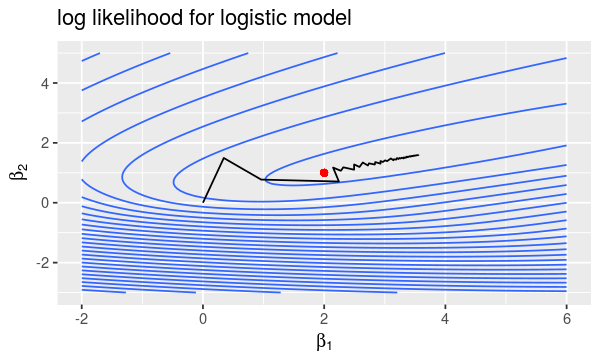

In [51]:
v <- ggplot(data=beta_grid, aes(beta1, beta2,z = log_like))
v <- v + geom_contour(bins=25)
v <- v +  labs(
        x = quote(beta[1]),
        y = quote(beta[2])
      )
v <- v +  geom_point(aes(x=beta[1],y=beta[2]), color="red")
v <- v + geom_path(data = beta_hat)
##v <- v +  geom_point(data=beta_hat,mapping=aes(x=beta1,y=beta2),color="blue")
v + labs(title = "log likelihood for logistic model")

**Exercise**: Try starting the ascent algorithm at different initial values and graphically monitor convergence.

**Exercise**: Try implementing an automatic stopping strategy so that when the parameter estimates do not change much after an iteration, the algorithm stops.


## Fit with R's Built In Function

R fits logistic regression using the `glm` function. glm standards for generalized linear models. This function can fit many models. We discuss some of its other functionality in future lectures.

In [52]:
fit <- glm(y~X-1,family="binomial")

In [53]:
beta_hat_R <- fit$coefficients

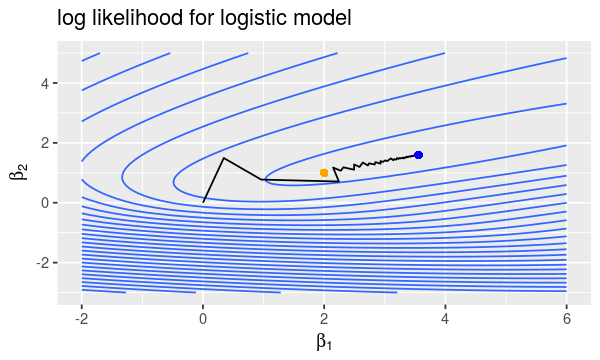

In [54]:
v <- ggplot(beta_grid, aes(beta1, beta2,z = log_like))
v <- v + geom_contour(bins=25)
v <- v +  labs(
        x = quote(beta[1]),
        y = quote(beta[2])
      )
v <- v +  geom_point(aes(x=beta[1],y=beta[2]), color="orange")
v <- v + geom_path(data = beta_hat)
v <- v +  geom_point(aes(x=beta_hat_R[1],y=beta_hat_R[2]), color="blue")
v + labs(title = "log likelihood for logistic model")

The blue point is the glm estimate. Our gradient method converges to this point.

The `glm` function is also using an iterative algorithm to find the maximum of the likelihood. We would like to track the path of the `glm` algorithm to compare to gradient ascent. As far as I can tell, there is no direct way to do this. However we can specify a starting point (using the `start` argument in the glm function). We can also specify a maximum number of iterations. So in order to record the path. we repeatedly start the algorithm (at the same initial value we used for gradient ascent) and increase the maximum number of iterations by 1.

In [56]:
Niter <- 10
beta_hat_glm <- matrix(0,nrow=Niter,ncol=2)
beta_hat_glm[1,] <- initial_beta
for(ii in 1:(Niter-1)){
    beta_hat_glm[ii+1,] <- glm(y~X-1,family="binomial",
                               start=initial_beta,maxit=ii)$coefficients
}

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: algorithm did not converge”

The warning messages are caused by us deliberately stopping the algorithm prematurely. This would cause concern in ordinary situations but is fine in testing.

In [57]:
## get parameter estimates in form for contour plot
## ggplots requires us to have log_like column, which
## we just fill with 0s
beta_hat_glm <- data.frame(beta_hat_glm,0)
colnames(beta_hat_glm) <- c("beta1","beta2","log_like")

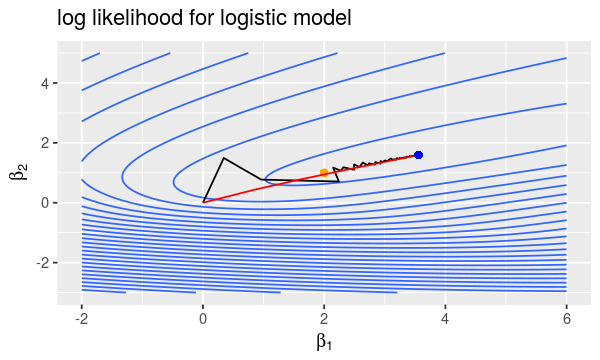

In [59]:
v <- ggplot(beta_grid, aes(beta1, beta2,z = log_like))
v <- v + geom_contour(bins=25)
v <- v +  labs(
        x = quote(beta[1]),
        y = quote(beta[2])
      )
v <- v +  geom_point(aes(x=beta[1],y=beta[2]), color="orange")
v <- v + geom_path(data = beta_hat)
v <- v + geom_path(data = beta_hat_glm,col='red')
v <- v +  geom_point(aes(x=beta_hat_R[1],y=beta_hat_R[2]), color="blue")
v + labs(title = "log likelihood for logistic model")

The `glm` optimizer converges in fewer iterations.

** Exercise: ** Select 2 classes of the `iris` data set and fit a logistic classifier on the four features using gradient ascent. Confirm that the algorithm converges. You can check this by comparing the results to the function `glm`.

** Exercise: ** Turn the gradient ascent code into a function that takes arguments such as x0 (initial guess), f (the function to maximize), df (gradient of f), and "data". The format for the data could be y, X for regression types application or something more general. Perhaps number of iterations could be a parameter value as well. Have the function output the estimate of argmax f and possibly the sequence of iteratates $x_1,x_2,\ldots$.